In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier

from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.decomposition import KernelPCA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA

from azureml.core import Workspace, Experiment

# from azureml.widgets import RunDetails
from azureml.train.sklearn import SKLearn
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.policy import BanditPolicy
from azureml.train.hyperdrive.sampling import RandomParameterSampling, BayesianParameterSampling
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.parameter_expressions import choice
from azureml.data.dataset_factory import TabularDatasetFactory
from azureml.widgets import RunDetails
from azureml.train.automl import AutoMLConfig
from azureml.core.compute import ComputeTarget, AmlCompute
import os

seed = 123


import warnings
warnings.filterwarnings("ignore")

In [2]:
path1 = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
X = pd.read_table(path1, header=None, delim_whitespace=True)

path2 = "http://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"
y = pd.read_table(path2, header=None, usecols=[0], squeeze=True, delim_whitespace=True)

In [3]:
x1,x2,y1,y2 = train_test_split(X,y, random_state=seed, shuffle=True, stratify=y)

In [4]:
x1

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
871,3212.46,2522.41,2200.2333,1173.8377,1.3281,100.0,101.6111,0.1211,1.4650,0.0035,...,NaN,NaN,0.4936,0.0131,0.0032,2.6457,0.0117,0.0262,0.0089,223.1018
385,3067.89,2570.93,2196.8000,1090.0084,1.3270,100.0,99.3944,0.1212,1.5001,-0.0199,...,0.0025,127.2483,0.4968,0.0096,0.0029,1.9411,0.0056,0.0071,0.0025,127.2483
611,2967.54,2573.09,2160.6000,1124.5821,1.5257,100.0,98.7122,0.1246,1.4750,0.0248,...,NaN,NaN,0.4973,0.0129,0.0030,2.6016,0.0252,0.0157,0.0046,62.3881
1494,3068.64,2498.02,2192.7556,867.3027,1.7393,100.0,123.4244,0.1251,1.4404,-0.0050,...,0.0085,414.4256,0.5029,0.0111,0.0032,2.1984,0.0068,0.0280,0.0085,414.4256
751,3080.89,2590.45,2162.7556,1006.7789,0.8736,100.0,106.8744,0.1220,1.4187,0.0012,...,0.0017,45.7004,0.4989,0.0167,0.0040,3.3541,0.0119,0.0054,0.0017,45.7004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,3182.35,2520.40,2187.7888,1350.3395,0.7945,100.0,101.9267,0.1200,1.4629,-0.0164,...,NaN,NaN,0.5023,0.0173,0.0040,3.4462,0.0169,0.0236,0.0076,139.6209
863,2997.94,2471.97,2214.1667,1705.2046,0.9113,100.0,100.4633,0.1231,1.4964,-0.0099,...,0.0057,136.9762,0.4991,0.0086,0.0026,1.7286,0.0140,0.0192,0.0057,136.9762
1459,3006.80,2536.87,NaN,NaN,NaN,NaN,NaN,0.0000,1.4814,0.0180,...,NaN,NaN,0.4974,0.0111,0.0034,2.2344,-0.0031,0.0168,0.0061,545.6838
1493,3002.54,2549.85,2182.5555,1261.0898,1.2110,100.0,112.2922,0.1252,1.2634,0.0052,...,NaN,NaN,0.5045,0.0181,0.0048,3.5944,0.0049,0.0123,0.0037,248.6235


In [5]:
print("The training set has ", x1.shape[0], "observations and ", x1.shape[1], "features")

The training set has  1175 observations and  590 features


In [6]:

x1.dtypes.value_counts()

float64    590
dtype: int64

All 590 are numerical features. Let's find how many columns have NaN values. 

In [7]:
na_columns = []
for col in x1.columns:
    if x1.loc[:,col].isna().sum() > 0:
        na_columns.append(col)
        
print("There are", len(na_columns), "features with at least 1 NaN")        

There are 418 features with at least 1 NaN


Let's see if there are columns that have <5 unique values. 

In [8]:
unique_columns = []
for col in x1.columns:
    if x1.loc[:,col].nunique() < 3:
        unique_columns.append(col)

len(unique_columns)

122

Now, let's see if the target labels are balanced.

In [9]:
y1.value_counts(normalize=True)

-1    0.933617
 1    0.066383
Name: 0, dtype: float64

Labels are not balanced, 93.3% of the observations are "Pass" and remaining are "Fail". Thus, the classifier must be abale to handle 'class_weight'. 

### Observations and modeling strategy:

1. All features are numerical
2. Majority of the features have null values => Imputation will be needed
3. Features have different scales => scaling will be required
4. 122 columns have less than 3 distinct values. This means either they have near constant variance or they might be categorical.  
5. Imbalanced dataset


Keeping this in mind, we will have to build a pipeline that will include:
1. Standarddization
2. Imputation
3. Variance Threshold to remove near-constant values as they will have less predictive power
4. Since number of features are very large, we will need to do dimentionality reduction
5. Typically, use F1 or AUC as the metric since the labels are imbalanced. Also the classifier must be able to handle 'class_weight'.
6. We will try three linear algorithms (Logistic, SVC, Ridge) and two tree-based (Random Forest & lightgbm), stacking ensemble and voting ensemble. All algorithms will be based on CV to measure its 'generalizability'.
7. Finally, the final model for hyperparameter tuning will be based on:
    - Simple
    - Parsimonious
    - Easy to maintain, debug and interpret

## Pipeline

In [10]:
fail_weight = y1.value_counts(normalize=True)[1]
pass_weight = 1-fail_weight

weights = {-1:pass_weight, 1:fail_weight}

#### Estimators

In [11]:
lr = LogisticRegression(random_state=seed, class_weight = weights)
rf = RandomForestClassifier(class_weight=weights, random_state=seed)
svc = SVC(class_weight = weights, random_state=seed)
lgbm = LGBMClassifier(objectibe='binary', random_state=seed)
ridge = RidgeClassifier(class_weight = weights, random_state=seed)
pca = PCA(n_components = 200)

stack = [('svc',svc), ('lgbm',lgbm), ('lr',lr), ('rf',rf)]

voting = VotingClassifier(stack, voting='soft')

stacking = StackingClassifier(stack, final_estimator=LogisticRegression())

In [12]:
#Define an empty dataframe to store results
result_df = pd.DataFrame()

#### Identify number components to keep in PCA

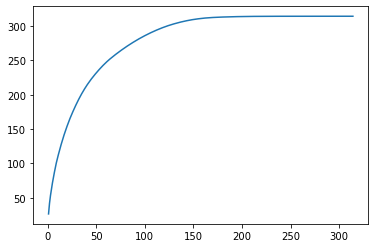

In [13]:
pca1=PCA()


clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),

])

x_x = clf2.fit_transform(x1)



pca1.fit(x_x)
v=pca1.explained_variance_
plt.plot(np.arange(1,len(v)+1), np.cumsum(v));

As can be seen from the plot above, the explained variance levels off after ~200 components. Thus, we can safely keep the first 200 components. This will reduce the number of features from 590 to 200

### Without PCA

In [14]:
name = "lr"

clf1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('classification', lr)
])
clf1.fit(x1, y1)

score1 = cross_val_score(clf1, X=x1, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name, 'auc':score1.mean(), 'auc_std':score1.std() }, ignore_index=True)

In [15]:
result_df

,Classifier,auc,auc_std
0,lr,0.665418,0.072825


#### Logistic Regression w/ PCA

In [16]:
name = "lr_PCA"

clf1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('PCA', pca),
    ('classification', lr)
])
clf1.fit(x1, y1)

score1 = cross_val_score(clf1, X=x1, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name, 'auc':score1.mean(), 'auc_std':score1.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr,0.665418,0.072825
1,lr_PCA,0.666702,0.073192


Using PCA, improved the AUC sightly. 

#### SVC w/ PCA

In [17]:
name = "svc_PCA"

clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('PCA', pca),
    ('classification', svc)
])
clf2.fit(x1, y1)

score2 = cross_val_score(clf2, X=x1, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr,0.665418,0.072825
1,lr_PCA,0.666702,0.073192
2,svc_PCA,0.675081,0.078973


#### Ridge w/ PCA

In [18]:
name = "ridge_PCA"

clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('PCA', pca),
    ('classification', ridge)
])
clf2.fit(x1, y1)

score2 = cross_val_score(clf2, X=x1, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr,0.665418,0.072825
1,lr_PCA,0.666702,0.073192
2,svc_PCA,0.675081,0.078973
3,ridge_PCA,0.634436,0.063144


#### LGBM w/ PCA

In [19]:
name = "lgbm_PCA"

clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('PCA', pca),
    ('classification', lgbm)
])
clf2.fit(x1, y1)

score2 = cross_val_score(clf2, X=x1, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr,0.665418,0.072825
1,lr_PCA,0.666702,0.073192
2,svc_PCA,0.675081,0.078973
3,ridge_PCA,0.634436,0.063144
4,lgbm_PCA,0.657564,0.053746


#### RandomForest w/ PCA

In [20]:
name = "rf_PCA"

clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('PCA', pca),
    ('classification', lgbm)
])
clf2.fit(x1, y1)

score2 = cross_val_score(clf2, X=x1, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr,0.665418,0.072825
1,lr_PCA,0.666702,0.073192
2,svc_PCA,0.675081,0.078973
3,ridge_PCA,0.634436,0.063144
4,lgbm_PCA,0.657564,0.053746
5,rf_PCA,0.636927,0.060807


#### VotingClassifier Ensemble w/ PCA

In [21]:
name = "voting"

lr = LogisticRegression(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
svc = SVC(random_state=seed, probability=True)
lgbm = LGBMClassifier(objectibe='binary', random_state=seed)
ridge1 = RidgeClassifier(random_state=seed)

stack = [('svc',svc), ('lgbm',lgbm), ('lr',lr), ('rf',rf)]

voting = VotingClassifier(stack, voting='soft')


clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('PCA', pca),
    ('classification', voting)
])
clf2.fit(x1, y1)

score2 = cross_val_score(clf2, X=x1, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr,0.665418,0.072825
1,lr_PCA,0.666702,0.073192
2,svc_PCA,0.675081,0.078973
3,ridge_PCA,0.634436,0.063144
4,lgbm_PCA,0.657564,0.053746
5,rf_PCA,0.636927,0.060807
6,voting,0.662538,0.064144


#### Stacking Ensemble w/ PCA

In [22]:
name = "stacking"

lr = LogisticRegression(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
svc = SVC(random_state=seed, probability=True)
lgbm = LGBMClassifier(objectibe='binary', random_state=seed)
ridge1 = RidgeClassifier(random_state=seed)

stack = [('svc',svc), ('lgbm',lgbm), ('lr',lr), ('rf',rf)]

stacking = StackingClassifier(stack, final_estimator=LogisticRegression())


clf2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('PCA', pca),
    ('classification', stacking)
])
clf2.fit(x1, y1)

score2 = cross_val_score(clf2, X=x1, y=y1, cv=5, scoring = 'roc_auc')

result_df = result_df.append({'Classifier':name , 'auc':score2.mean(), 'auc_std':score2.std() }, ignore_index=True)

result_df

,Classifier,auc,auc_std
0,lr,0.665418,0.072825
1,lr_PCA,0.666702,0.073192
2,svc_PCA,0.675081,0.078973
3,ridge_PCA,0.634436,0.063144
4,lgbm_PCA,0.657564,0.053746
5,rf_PCA,0.636927,0.060807
6,voting,0.662538,0.064144
7,stacking,0.654393,0.060774


,Classifier,auc,auc_std
0,lr,0.665418,0.072825
1,lr_PCA,0.666702,0.073192
2,svc_PCA,0.675081,0.078973
3,ridge_PCA,0.634436,0.063144
4,lgbm_PCA,0.657564,0.053746
5,rf_PCA,0.636927,0.060807
6,voting,0.662538,0.064144
7,stacking,0.654393,0.060774


## Observations:

1. SVC classfier has the best AUC of 67.5% followed by Logistic Regression at 66.6%
2. The AUC scores are moderate and do not indicate that the features can't predict the pass/fail labels very accurately
3. PCA reduced the number of features from 590 to 200. This will significantly reduce the train/inference times. Reducing the number of features did not affect the AUC much, in fact it improved it slightly.
4. Using PCA makes the model less interpretable
5. Using ensemble methods did not result in improving the best individual model 
6. All scores are based on mean cross-validated AUC. Std deviation of the AUC shows not significant deviation from mean. Hence we can expect the final model to generalize well witin AUC [0.6-0.74]
7. Hyperdrive will be used to further tune the SVC + PCA model. All other transformations will be kept the same

# Create train.py

In [30]:
%%writefile train.py

'''

Training script for Udacity Project 3
Sandeep Pawar
Ver 1
Date Jan 25, 2021

'''
import numpy as np
import pandas as pd
import argparse
from azureml.core.run import Run


from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.impute import SimpleImputer

from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import KernelPCA, PCA
from sklearn.svm import SVC

seed = 123


import warnings
warnings.filterwarnings("ignore")

run = Run.get_context()

def load_data(dataframe):
    
    # Load data with all the columns from the source
    # x is teh training data
    # y is the label for the training data
    
    x = dataframe.drop('y', axis=1)
    
    y = dataframe['y'] 
    
    return x, y 

x, y = load_data(dataframe)

def main():
    
    parser = argparse.ArgumentParser()
    
    weights = {-1:0.9334, 1:(1-0.9334)}

    parser.add_argument('--impute', type=str, default='median', help="Imputation Strategy")
    parser.add_argument('--kernel', type=str, default="rbf", help="Kernel for SVC")
    parser.add_argument('--gamma', type=str, default='auto', help="Gamma value")
    parser.add_argument('--penalty', type=float, default=1, help="Penalty")

    args = parser.parse_args()

    run.log("Imputation:", str(args.impute))
    run.log("kernel:", str(args.kernel))
    run.log("Gamma:", str(args.gamma))
    run.log("penalty:", str(args.penalty))
    
    clf = Pipeline([
    ('imputer', SimpleImputer(strategy=args.impute)), # To impute missing values
    ('threshold', VarianceThreshold(0.01)), # Remove near-constant features
    ('scaler', StandardScaler()),
    ('PCA', PCA(n_components = 200)),
    ('classification', (SVC(class_weight = weights, 
                           random_state=seed, 
                           kernel = args.kernel, 
                           C = args.penalty,
                           gamma = args.gamma, 
                           probability =True)))
    ])
        
    clf.fit(x, y)    
    
    score = cross_val_score(clf, X=x, y=y, cv=5, scoring = 'roc_auc')
        
    
    run.log("Mean_AUC", np.float( score.mean()))

    #Serialize the model
    os.makedirs('outputs', exist_ok=True)
    joblib.dump(clf, 'outputs/hyperDrive_{}_{}'.format(args.kernel,args.gamma, args.penalty))

if __name__ == '__main__':
    main()

Writing train.py


# Create Azure ML Hyperdrive

### Define Azure Workspace & Compute

In [ ]:
ws =Workspace.from_config()
exp = Experiment(workspace=ws, name="Project3")

print(ws.get_details()['id'])

compute_name = "DS2V2"



try:
    vm = ComputeTarget(ws, compute_name)
    print(f"{compute_name} exists already")
except:
    compute_config = AmlCompute.provisioning_configuration(vm_size="Standard_D2_V2", max_nodes=4)
    vm = ComputeTarget.create(ws, compute_name, compute_config)
    
vm.wait_for_completion(show_output=True)

### Define Hyperdrive Config

In [ ]:
# Specify parameter sampler



param_space = { 
                                    "--impute"     : choice('mean', 'median'), 
                                    "--kernel": choice("rbf","linear"),
                                    "--gamma": choice("auto","scale"),
                                    "--penalty": choice(0.01,1,10,20,100)  
                                    
              }

sampling = RandomParameterSampling(param_space)

# Specifying Bandit Policy. 
# ROC will be evaluated at every run, starting from 21st run. 
# If the performance in the successive runs is below 91% of the best performing run, HPO will be stopped


policy = BanditPolicy(evaluation_interval=1, slack_factor=0.1, delay_evaluation=20)


if "training" not in os.listdir():
    os.mkdir("./training")
import shutil
shutil.copy('train.py', './training')
    
# Create a SKLearn estimator for use with train.py
est = SKLearn(source_directory='./training', 
              compute_target=vm, 
              entry_script='train.py')

# Create a HyperDriveConfig using the estimator, hyperparameter sampler, and policy.
hyperdrive_config = HyperDriveConfig(estimator=est, 
                                     policy=policy, 
                                     primary_metric_name="AUC",
                                     hyperparameter_sampling=sampling,
                                     max_total_runs=200,
                                     primary_metric_goal=PrimaryMetricGoal.MAXIMIZE)